# Create mask
Code opening a single data set in the .h5 format used at the P10 Coherence Applications beamline.
We average over all frames and save them such that they can be openend with the PyFAI drawmask tool.
In the last block, the PyFAI mask is inverted, saved and plotted

In [1]:
import h5py
import hdf5plugin
import numpy as np
import matplotlib.pyplot as plt
import fabio # for opening .edf files

def folder_structure(name, node): #use for f.visititems(folder_structure) to see entries of hdf5 file
    if isinstance(node, h5py.Group):
        print(node.name)
    elif isinstance(node, h5py.Dataset):
        if (node.dtype == 'object') :
            print (node.name, 'contains numeric data')
        else:
            print('\t', node.name, node.shape)


blosc filter already loaded, skip it.
bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.
zstd filter already loaded, skip it.
fcidecomp filter already loaded, skip it.


In [13]:
sample = 'm029_eggwhite_70C_bd' #sample/measurement name
series = 1 # number of XPCS series within measurement
with h5py.File(f'../../raw/{sample}_{series:05d}/e4m/{sample}_{series:05d}_data_000001.h5', 'r') as f: #path to file for mask creation
    f.visititems(folder_structure) #display file content

/entry
/entry/data
	 /entry/data/data (2000, 2167, 2070)


In [14]:
# sum over time and save for masking
with h5py.File(f'../../raw/{sample}_{series:05d}/e4m/{sample}_{series:05d}_data_000001.h5', 'r') as f:
    sum_series = np.sum(f['/entry/data/data'], axis=0) # sum 3d-array over time axis
np.save(f'{sample}_4mask.npy',sum_series) # save as npy file

<IPython.core.display.Javascript object>


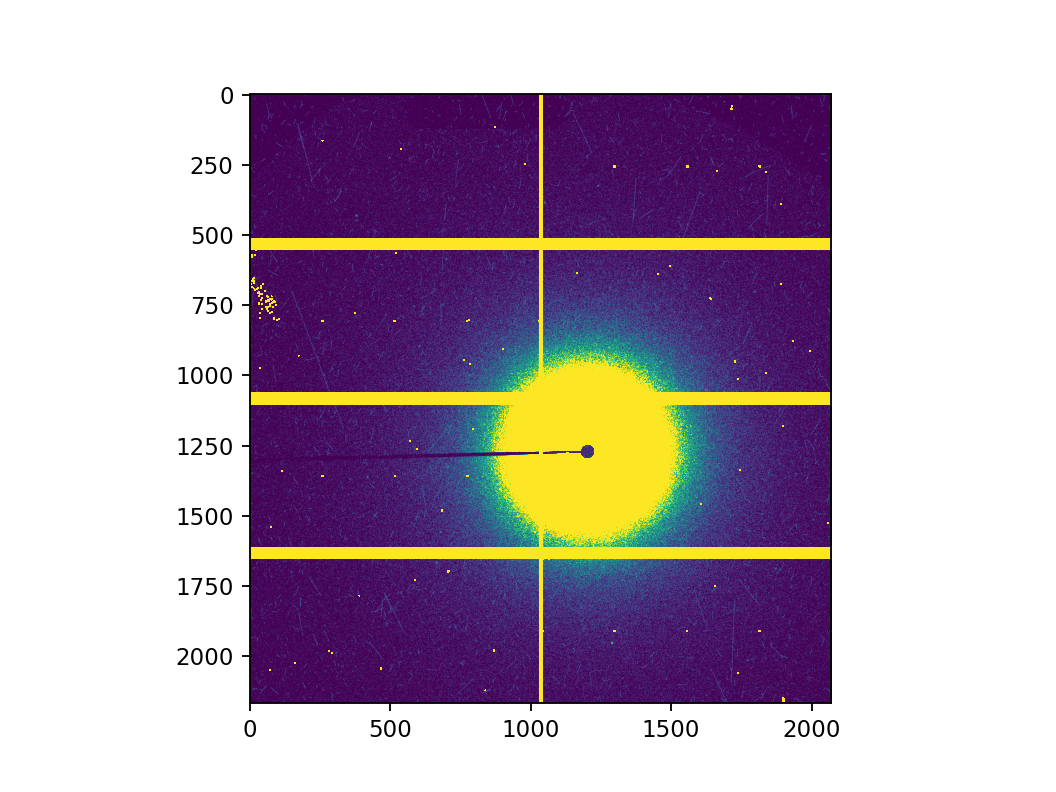

In [17]:
#show accumulated scattered intensity
%matplotlib notebook
fig, ax = plt.subplots()
ax.imshow(sum_series,vmax=3)

The masking itself is done with the PyFAI drawmask tool which needs to be run outside of the notebook. In DESY's maxwell cluster, this can be done in max-display: open terminal in folder and run `pyFAI-drawmask {sample}_4mask.npy`. A GUI will pop up and at the end, a numpy or edf (default) file can be saved.

In [3]:
#reload mask created with pyFAI
mask = fabio.open(f'{sample}_4mask_mask.edf').data

In [5]:
#switch 0s and 1s such that 0=mask pixel and 1=use pixel. 
#With this notation, masking can be performed as multiplication by the mask array
mask = np.where((mask==0)|(mask==1), mask^1, mask)
mask=(mask!=0)

In [6]:
np.save('e4m_mask.npy',mask) # save mask as numpy file. 

<IPython.core.display.Javascript object>


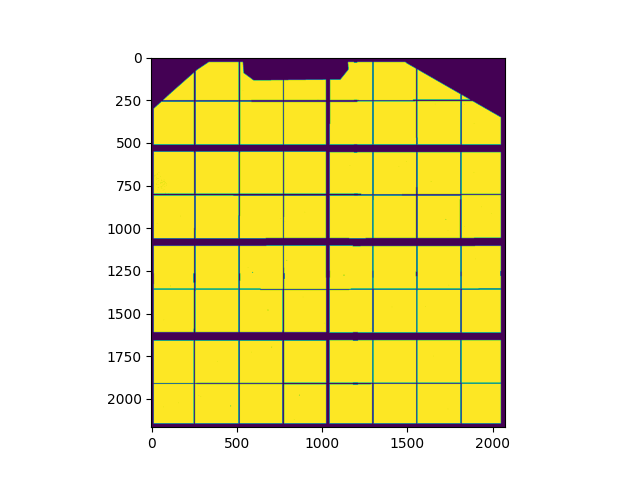

In [11]:
#plot mask
%matplotlib notebook
plt.imshow(np.multiply(mask,1),vmax=1)

## Test mask with data set

In [3]:
sample = 'm029_eggwhite_70C_bd' #sample/measurement name
series = 1 # number of XPCS series within measurement
with h5py.File(f'../../raw/{sample}_{series:05d}/e4m/{sample}_{series:05d}_data_000001.h5', 'r') as f: #path to file for mask creation
    data_array = f['entry/data/data'][()]

In [4]:
mask = np.load('e4m_mask.npy') # load mask

In [5]:
masked_data = np.multiply(data_array,mask) # multiply mask and data to set unwanted pixels to 0

<IPython.core.display.Javascript object>


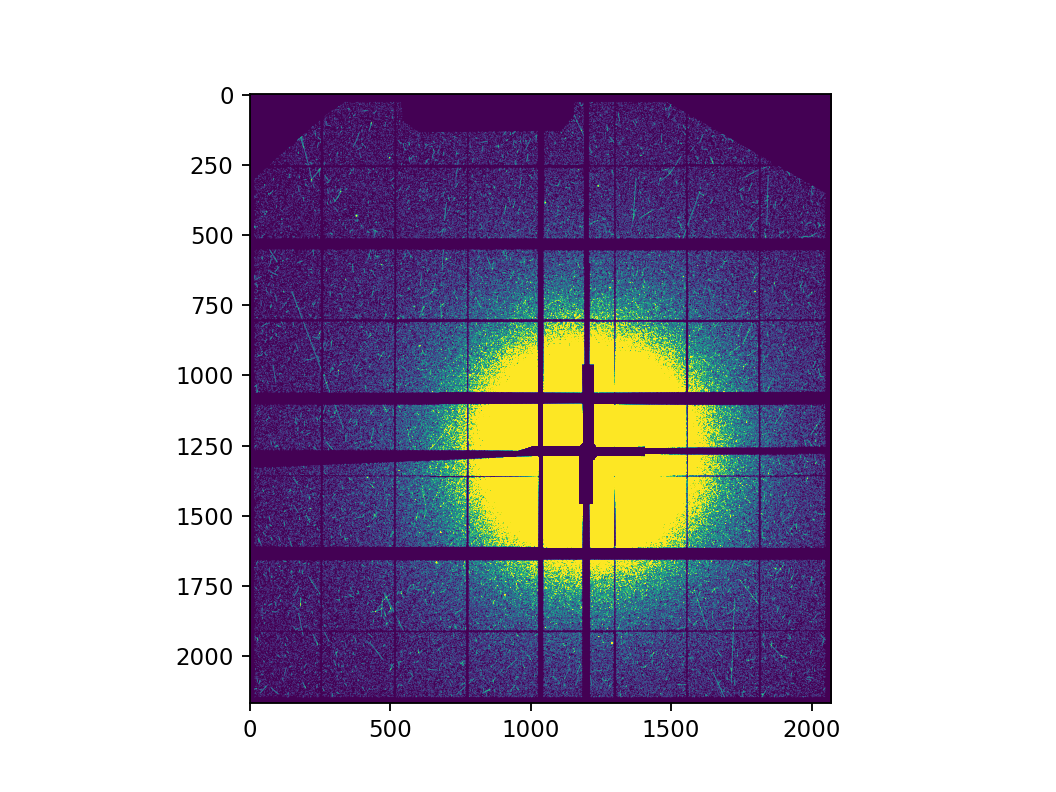

In [11]:
#display subset of data with mask 
%matplotlib notebook
fig, ax = plt.subplots()
ax.imshow(np.sum(masked_data[:,:,:],axis=0),vmax=1)

In [7]:
# possibility to save masked data set for further analyses purposes
np.save('masked_dataset_A.npy',masked_data)